In [2]:
#Spring 2019 Network Science Project Code
#Load packages
import networkx as nx
import os
import pandas as pd
import numpy as np
import math
import random
import powerlaw
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
#load dataset
cwd = os.getcwd()

chatter_data_raw = pd.read_csv(cwd+'\\Data\\chatter_activity_clean.csv', encoding='utf-8')

print(chatter_data_raw.shape)
#print(chatter_data_raw.dtypes)
#chatter_data_raw.head()

chatter_data_raw = chatter_data_raw.loc[chatter_data_raw['Name'].isin(
    ['Enterprise Data Services & Operations'])]
print(chatter_data_raw.shape)
#chatter_data_raw.head()

(3854, 8)
(2465, 8)


In [4]:
#load user data to join as attributes
user_data = pd.read_csv(cwd+'\\Data\\user_details_clean.csv', encoding='utf-8')

user_data = user_data.fillna(0)
#bucket the jobgrades
user_data['JobGrade'] = user_data['JobGrade'].apply(int)
#bucket the Tenure Groups
user_data['JobGrade_Group'] = 'N/A'
user_data.loc[user_data['JobGrade'] == 0,'JobGrade_Group'] = 'N/A'
user_data.loc[(user_data['JobGrade'] >= 1) & (user_data['JobGrade'] < 4 ), 'JobGrade_Group'] = '< 4'
user_data.loc[(user_data['JobGrade'] >= 4) & (user_data['JobGrade'] < 7 ), 'JobGrade_Group'] = '4 to 6'
user_data.loc[(user_data['JobGrade'] >= 7) & (user_data['JobGrade'] < 12 ), 'JobGrade_Group'] = '7 to 11'
user_data.loc[user_data['JobGrade'] >= 12,'JobGrade_Group'] = '> 11'
user_data['JobGrade'] = user_data['JobGrade'].astype(str)

user_data['Tenure'] = user_data['Tenure'] / 365
user_data = user_data.round({'Tenure': 0})
user_data['Tenure'] = user_data['Tenure'].apply(int)
#bucket the Tenure Groups
user_data['Tenure_Group'] = 'N/A'
user_data.loc[user_data['Tenure'] < 1,'Tenure_Group'] = '< 1 yr'
user_data.loc[(user_data['Tenure'] >= 1) & (user_data['Tenure'] < 4 ), 'Tenure_Group'] = '1 to 3 yrs'
user_data.loc[(user_data['Tenure'] >= 4) & (user_data['Tenure'] < 8 ), 'Tenure_Group'] = '4 to 8 yrs'
user_data.loc[user_data['Tenure'] >= 8,'Tenure_Group'] = '> 8 yrs'
user_data['Tenure'] = user_data['Tenure'].astype(str)

user_data['Pronoun'] = user_data['Pronoun'].astype(str)
user_data['WorkLocation'] = np.where(user_data['WorkLocation'].str.contains('Remote'), "Remote", user_data['WorkLocation'])
user_data['WorkLocation'] = np.where(user_data['WorkLocation'].isin(['United Kingdom - Staines','United Kingdom - London']), 
                                     "United Kingdom", user_data['WorkLocation'])

print(user_data.shape)

(43217, 10)


In [5]:
#join chatter group data with user data
chatter_data = chatter_data_raw.join(user_data.set_index('USER_NAME_ID'), on='USER_NAME_ID', 
                                     rsuffix='_poster', how='left')
chatter_data = chatter_data.join(user_data.set_index('USER_NAME_ID'), on='USER_NAME_ID_commenter', 
                                 rsuffix='_commenter', how='left')

In [6]:
#Consolidate any work location with less then 20 as other

other = []
for k, v in Counter(chatter_data['WorkLocation_commenter'].tolist()).items():
    if v < 20:
        other.append(k)
        
chatter_data['WorkLocation'] = np.where(chatter_data['WorkLocation'].isin(other), "Other", chatter_data['WorkLocation'])
chatter_data['WorkLocation_commenter'] = np.where(chatter_data['WorkLocation_commenter'].isin(other), "Other", 
                                                  chatter_data['WorkLocation_commenter'])

worklocation_count = Counter(chatter_data['WorkLocation_commenter'].tolist())
print(worklocation_count)

Counter({'California - San Francisco': 1475, 'Remote': 274, 'Texas - Dallas': 209, 'India - Hyderabad': 117, nan: 107, 'Ireland - Dublin': 91, 'Other': 83, 'Indiana - Indianapolis': 56, 'Illinois - Chicago': 35, 'Japan - Tokyo': 25, 'United Kingdom': 21})


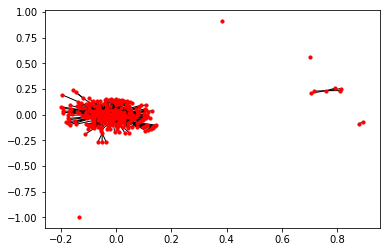

In [7]:
#create network
G = nx.Graph()
target_list = chatter_data['USER_NAME_ID'].unique().tolist()

for t in target_list:
    chatter_single_user = chatter_data.loc[chatter_data['USER_NAME_ID'] == t]
    
    #get list for person posting the original comment
    target = chatter_single_user['USER_NAME_ID'].unique().tolist()
    tenure = chatter_single_user['Tenure_Group'].unique().tolist()
    job_grade = chatter_single_user['JobGrade_Group'].unique().tolist()
    WorkLocation = chatter_single_user['WorkLocation'].unique().tolist()
    pronoun = chatter_single_user['Pronoun'].unique().tolist()
    
    #create list of all people who have interacted with targets original post
    poster = chatter_single_user['USER_NAME_ID_commenter'].unique().tolist()
    
    #calculate the weight based on the number of interactions between a poster and original commenter
    weight = Counter(chatter_single_user['USER_NAME_ID_commenter'].tolist())
    
    G.add_node(target[0], tenure = tenure[0], job_grade = job_grade[0], 
               WorkLocation = WorkLocation[0], pronoun = pronoun[0])
    for i in range(len(poster)): 
        #get information about person posting on original comment
        poster_details = chatter_data.loc[chatter_data['USER_NAME_ID_commenter'] == poster[i]]
        
        tenure2 = poster_details['Tenure_Group_commenter'].unique().tolist()
        job_grade2 = poster_details['JobGrade_Group_commenter'].unique().tolist()
        WorkLocation2 = poster_details['WorkLocation_commenter'].unique().tolist()
        pronoun2 = poster_details['Pronoun_commenter'].unique().tolist()
        
        #add poster node and create edge between poster and target
        G.add_node(poster[i], tenure = tenure2[0], job_grade = job_grade2[0], 
                   WorkLocation = WorkLocation2[0], pronoun = pronoun2[0])
        G.add_edge(target[0], poster[i], weight=weight.get(poster[i]))

nx.draw_networkx(G, pos=None, node_size = 10, with_labels=False)
plt.show()

In [8]:
#export as gexf file
G_max = max( (G.subgraph(c) for c in nx.connected_components(G) ), key=len)
print(nx.number_connected_components(G))

G_max = nx.Graph(G_max)
print(type(G_max).__name__)

nx.write_gexf(G_max, "DataOps.gexf")

6
Graph


In [9]:
def neighbor_degree(node, nxgraph):
    avg_degree = np.mean([nxgraph.degree(n) for n in nxgraph.neighbors(node)])
    return avg_degree

def friendship_paradox(nxgraph):
    pdox_ct = 0
    for n in nxgraph.nodes():
        if nxgraph.degree(n) < neighbor_degree(n, nxgraph):
            pdox_ct += 1
    return pdox_ct / len(nxgraph)

In [10]:
print(nx.info(G_max))
print('Friendship Paradox: '+str(round(friendship_paradox(G_max),4)))
print('Graph Density: '+str(round(nx.density(G_max),4)))
print('Graph Diameter: '+str(round(nx.diameter(G_max),4)))
print('Avg Clustering Coefficient: '+str(round(nx.average_clustering(G_max),4)))
print('Avg Shortest Path: '+str(round(nx.average_shortest_path_length(G_max, weight=None),4)))

Name: 
Type: Graph
Number of nodes: 283
Number of edges: 883
Average degree:   6.2403
Friendship Paradox: 0.9152
Graph Density: 0.0221
Graph Diameter: 6
Avg Clustering Coefficient: 0.2104
Avg Shortest Path: 3.0412


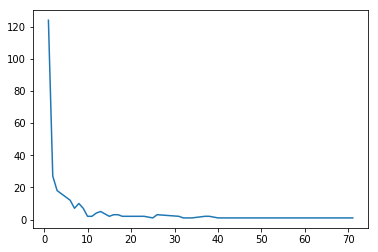

In [11]:
deg_seq = list(dict(nx.degree(G_max)).values())
nk = Counter(deg_seq)

x = []
y = []
for k in sorted(nk):
    x.append(k)
    y.append(nk[k])
    
plt.plot(x,y)
plt.show()

Calculating best minimal value for power law fit
c:\users\ahilgenkamp\appdata\local\programs\python\python36\lib\site-packages\powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Calculating best minimal value for power law fit


5.0
2.197970690097585
5.013621660891876 2.1783664733227424


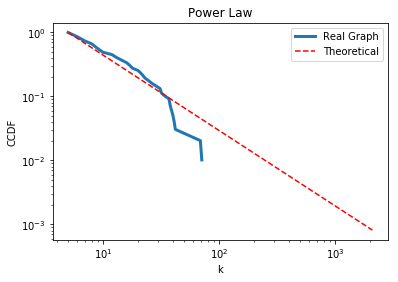

In [15]:
# Find the cut-off
node_degrees = deg_seq
fit = powerlaw.Fit(node_degrees)
print(fit.xmin)

# estimate the scaling exponent
alpha = fit.power_law.alpha
print(alpha)

# plot vs theoretical distribution
theoretical_distribution = powerlaw.Power_Law(xmin=5.0, parameters=[2.19])
simulated_data = theoretical_distribution.generate_random(1000)
fit2 = powerlaw.Fit(simulated_data)
print( fit2.power_law.xmin, fit2.power_law.alpha )

fig = fit.plot_ccdf(linewidth=3, label='Real Graph')
fit2.power_law.plot_ccdf(ax=fig, color='r', linestyle='--', label='Theoretical')
plt.title('Power Law')
plt.ylabel("CCDF")
plt.xlabel("k")
plt.legend()

plt.show()

### Complex Contagion

In [16]:
# threshold model copied from https://github.com/yy/netsci-course/blob/master/m12-diffusion/threshold_model_assignment.ipynb
def threshold_model(graph, mean, std):
    threshold_distribution = np.random.normal(mean, std, size=len(graph))
    node_thresholds = { node: threshold_distribution[i] for i, node in enumerate(graph.nodes()) }
    seed_node = np.random.choice(graph.nodes())
    seed_neighbors = list(graph[seed_node].keys())
    seed_neighbors.append(seed_node)
    seeds = set(seed_neighbors)
    inactive_nodes = set(graph.nodes()) - seeds
    previous_set = set([])
    while (previous_set != inactive_nodes):
        previous_set = set(inactive_nodes)
        update_sequence = list(inactive_nodes)
        random.shuffle(update_sequence)
        for node in update_sequence:
            num_active_neighbors = np.sum([ 0 if neighbor in inactive_nodes else 1 
                                           for neighbor in graph.neighbors(node)])
            if (num_active_neighbors >= node_thresholds[node]):
                inactive_nodes.remove(node)
                
    return 1 - len(inactive_nodes) / len(graph)

In [17]:
means = np.linspace(0.0, 6.0, 30)
stds = np.linspace(0.01, 20.0, 30)
deg_seq = list(dict(nx.degree(G_max)).values())

config = nx.configuration_model(deg_seq)
config = max( (config.subgraph(c) for c in nx.connected_components(config) ), key=len)
config = nx.Graph(config)

er = nx.erdos_renyi_graph(283, 0.022)

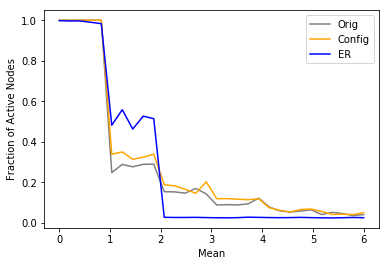

In [18]:
ax = plt.subplot(111)
ax.plot(means, [ np.mean([threshold_model(G_max, mean, 0.01) 
                           for i in range(150) ]) 
                 for mean in means], color='gray', label='Orig')
ax.plot(means, [ np.mean([threshold_model(config, mean, 0.01) 
                           for i in range(150) ])
                 for mean in means], color='orange', label='Config')
ax.plot(means, [ np.mean([threshold_model(er, mean, 0.01) 
                           for i in range(150) ]) 
                 for mean in means], color='blue', label='ER')
plt.ylabel("Fraction of Active Nodes")
plt.xlabel("Mean")
ax.legend()
plt.show()

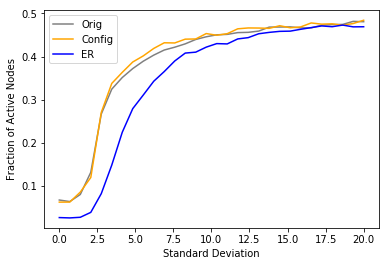

In [19]:
ax = plt.subplot(111)
ax.plot(stds, [ np.mean([threshold_model(G_max, 5, std) 
                           for i in range(150) ]) 
                 for std in stds], color='gray', label='Orig')
ax.plot(stds, [ np.mean([threshold_model(config, 5, std) 
                           for i in range(150) ])
                 for std in stds], color='orange', label='Config')
ax.plot(stds, [ np.mean([threshold_model(er, 5, std) 
                           for i in range(150) ]) 
                 for std in stds], color='blue', label='ER')
plt.ylabel("Fraction of Active Nodes")
plt.xlabel("Standard Deviation")
ax.legend()
plt.show()

### Simple Contagion

In [20]:
# Model copied from https://github.com/yy/netsci-course/blob/master/m10-epidemics/epidemics_assignment.ipynb
def SI(graph, tmax, beta, initial_inf):
    inf_o = set(np.random.choice(graph.nodes(), size=initial_inf, replace=False))
    nx.set_node_attributes(graph, {node: ([1] if node in inf_o else [0]) for node in graph.nodes()},'inf')
    
    for t in range(tmax):    
        for node in graph.nodes():
            if graph.node[node]['inf'][t] == 0:
                num_inf_neighbors = np.sum([ graph.node[neighbor]['inf'][t] for neighbor in graph.neighbors(node)])
                if np.random.random() < (1 - (1 - beta)**num_inf_neighbors):
                    graph.node[node]['inf'].append(1)          
                else:
                    graph.node[node]['inf'].append(graph.node[node]['inf'][t])
            else:
                graph.node[node]['inf'].append(graph.node[node]['inf'][t])
    return [ np.mean([ graph.node[node]['inf'][t] for node in graph.nodes() ]) for t in range(tmax)]

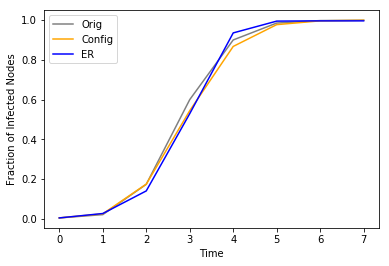

In [21]:
ax = plt.subplot(111)
ax.plot(np.mean([SI(G_max, tmax=8, beta=0.9, initial_inf=1) for i in range(50)], axis=0), color='gray', label='Orig')
ax.plot(np.mean([SI(config, tmax=8, beta=0.9, initial_inf=1) for i in range(50)], axis=0), color='orange', label='Config')
ax.plot(np.mean([SI(er, tmax=8, beta=0.9, initial_inf=1) for i in range(50)], axis=0), color='blue', label='ER')
plt.ylabel("Fraction of Infected Nodes")
plt.xlabel("Time")
ax.legend()
plt.show()